In [1]:
import numpy as np
from numpy.linalg import eig, inv, pinv, eigvals
import pandas as pd
from scipy.spatial.distance import squareform 
from scipy.sparse import csr_matrix, random as sparse_random, find, issparse
from scipy.sparse import isspmatrix
from scipy.sparse.linalg import svds
from scipy.linalg import eigh
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvnpdf
import cvxpy as cp
import time
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from numpy.matlib import repmat
import scipy.sparse as sp

from scipy.sparse import coo_matrix, csc_matrix
np.random.seed(17307946)



In [2]:

def gsp_compute_theta_bounds(Z, geom_mean=0, is_sorted=0):
    """
    Python equivalent of gsp_compute_theta_bounds.m
    
    Parameters
    ----------
    Z : ndarray (n x n)
        Zero-diagonal pairwise distance matrix between nodes.
    geom_mean : int or bool, optional
        If 0, use arithmetic mean. If 1, use geometric mean. Default: 0.
    is_sorted : int or bool, optional
        If 1, Z is already sorted row-wise (excluding diagonal). Default: 0.

    Returns
    -------
    theta_l : ndarray
        Lower bounds of theta for each sparsity level.
    theta_u : ndarray
        Upper bounds of theta for each sparsity level.
    Z_sorted : ndarray
        The sorted version of Z (excluding diagonals).
    """
    Z = np.asarray(Z, dtype=np.float64)
    n = Z.shape[0]

    # If Z is a matrix
    if not is_sorted:
        # We must sort each row excluding the diagonal
        Z_sorted = np.zeros((n, n-1), dtype=np.float64)
        for i in range(n):
            row_indices = list(range(n))
            row_indices.remove(i)
            row_vals = Z[i, row_indices]
            Z_sorted[i,:] = np.sort(row_vals)
    else:
        Z_sorted = Z

    m, n_minus_1 = Z_sorted.shape
    # B_k = cumsum(Z_sorted, axis=1)
    B_k = np.cumsum(Z_sorted, axis=1)

    # K_mat = repmat((1:n-1), m, 1)
    K_mat = np.tile(np.arange(1, n_minus_1+1), (m,1))

    # Compute upper bounds
    # term inside sqrt: K_mat * Z_sorted.^2 - B_k * Z_sorted
    # Careful with elementwise operations
    # Z_sorted^2:
    Z_sq = Z_sorted**2
    numerator = K_mat * Z_sq
    denominator = B_k * Z_sorted
    inside_sqrt = numerator - denominator

    # We must ensure no negative values inside sqrt:
    # Theoretically it should be positive, but due to numerical issues, clip if needed:
    inside_sqrt = np.maximum(inside_sqrt, 1e-14)

    # 1./sqrt(...)
    values = 1.0 / np.sqrt(inside_sqrt)

    if geom_mean == 0:
        # Arithmetic mean along rows, then mean along rows
        theta_u = np.mean(values, axis=0)
    else:
        # Geometric mean:
        # geometric mean = exp(mean(log(x))) for x>0
        # ensure x>0
        log_vals = np.log(values)
        theta_u = np.exp(np.mean(log_vals, axis=0))

    # theta_l = [theta_u(2:end), 0]
    # In MATLAB indexing, theta_l(k) = theta_u(k+1) for k=1,...,n-2 and theta_l(n-1)=0
    # In Python indexing:
    theta_l = np.zeros_like(theta_u)
    if len(theta_u) > 1:
        theta_l[:-1] = theta_u[1:]
    theta_l[-1] = 0

    return theta_l, theta_u, Z_sorted


def gsp_compute_graph_learning_theta(Z, k, geom_mean=0, is_sorted=0):
    """
    Python equivalent of gsp_compute_graph_learning_theta.m
    
    Parameters
    ----------
    Z : ndarray (n x n)
        Zero-diagonal pairwise distance matrix.
    k : int
        Desired sparsity level (number of neighbors/node).
    geom_mean : int or bool, optional
        If 0, use arithmetic mean. If 1, use geometric mean. Default: 0.
    is_sorted : int or bool, optional
        If 1, Z is already sorted. Default: 0.

    Returns
    -------
    theta : float
        Computed theta value for given k.
    theta_min : float
        Lower bound for this k.
    theta_max : float
        Upper bound for this k.
    """
    theta_min_arr, theta_max_arr, _ = gsp_compute_theta_bounds(Z, geom_mean, is_sorted)

    # k indexing: In MATLAB, k is from 1 to n-1. 
    # Ensure k indexing is consistent.
    # In MATLAB code, it sets:
    # theta_min = theta_min(k); theta_max = theta_max(k);
    # arrays are zero-based in Python, so we use k-1 index:
    theta_min = theta_min_arr[k-1]
    theta_max = theta_max_arr[k-1]

    if k > 1:
        theta = np.sqrt(theta_min * theta_max)
    else:
        # if k=1, theta = theta_min * 1.1
        # Replicate MATLAB logic
        theta = theta_min * 1.1

    return theta


def gsp_symmetrize(W, sym_type='full'):
    """
    Python equivalent of gsp_symmetrize.m that handles both dense and sparse matrices.
    
    Parameters
    ----------
    W : ndarray or scipy.sparse matrix
        Square matrix to be symmetrized.
    sym_type : str, optional
        Type of symmetrization. Options are:
        - 'average': average of W and W.T ( (W+W.T)/2 )
        - 'full':    copy missing entries ( W = max(W, W.T) )
        - 'none':    do nothing
        Default is 'full'.
    
    Returns
    -------
    W_sym : ndarray or scipy.sparse matrix
        Symmetrized matrix.
    """
    if issparse(W):
        if sym_type == 'average':
            W_sym = (W + W.transpose()) * 0.5
        elif sym_type in ['full', 'maximum']:
            W_sym = W.maximum(W.transpose())
        elif sym_type == 'none':
            W_sym = W
        else:
            raise ValueError(f"gsp_symmetrize: Unknown type '{sym_type}'")
    else:
        if sym_type == 'average':
            W_sym = (W + W.T) / 2.0
        elif sym_type in ['full', 'maximum']:
            W_sym = np.maximum(W, W.T)
        elif sym_type == 'none':
            W_sym = W
        else:
            raise ValueError(f"gsp_symmetrize: Unknown type '{sym_type}'")
    return W_sym

In [3]:


def sum_squareform(n, mask=None):
    """
    Computes the sum and transpose sum matrices in a squareform format.

    Parameters:
    -----------
    n : int
        The size of the squareform matrix.

    mask : array-like, optional
        A mask to filter the indices. The length of the mask must be n(n-1)/2.
        If provided, only the elements corresponding to the non-zero values in
        the mask are considered.

        Returns:
    --------
    S : csr_matrix
        A sparse matrix of shape (n, n_cols), where n_cols = n(n-1)/2 if no mask is given.
        When a mask is provided, n_cols = nnz(mask).

    St : csr_matrix
        A sparse matrix of shape (n_cols, n), where n_cols = n(n-1)/2 if no mask is given,
        or n_cols = nnz(mask) if a mask is provided.

    Raises:
    -------
    ValueError
        If the length of the mask is not equal to n(n-1)/2.
    """
    if mask is not None:
        mask = np.asarray(mask).flatten()
        if len(mask) != n * (n - 1) // 2:
            raise ValueError('Mask size has to be n(n-1)/2')

        ind_vec = np.flatnonzero(mask)
        ncols = len(ind_vec)

        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        curr_row = 0
        offset = 0
        len_row = n - 1
        for ii in range(ncols):
            ind_vec_i = ind_vec[ii]
            while ind_vec_i >= (len_row + offset):
                offset += len_row
                len_row -= 1
                curr_row += 1
            I[ii] = curr_row
            J[ii] = ind_vec_i - offset + curr_row + 1

    else:
        ncols = (n * (n - 1)) // 2
        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        k = 0
        for i in range(n):
            for j in range(i + 1, n):
                I[k] = i
                J[k] = j
                k += 1

    St = csr_matrix((np.ones(ncols), (np.arange(ncols), I)), shape=(ncols, n))
    S = csr_matrix((np.ones(ncols), (np.arange(ncols), J)), shape=(ncols, n)).T + St.T

    return S, St




In [4]:




def normest(S):
    """
    Estimate the 2-norm (largest singular value) of a sparse matrix S.
    """
    u, s, vt = svds(S, k=1)
    return s[0]



def prox_sum_log(x, gamma, param=None):
    """
    Proximal operator of log-barrier - sum(log(x))

    This function solves:
        sol = argmin_z 0.5*||x - z||_2^2 - gamma * sum(log(z))

    Parameters:
    x : Input signal (vector or matrix)
    gamma : Regularization parameter
    param : Dictionary of optional parameters
        param['verbose']: Verbosity level. 0: no output, 1: print final_eval, 2: print warning if there are negative elements.

    Returns:
    sol : Solution
    info : Dictionary summarizing information at convergence
    """
    if param is None:
        param = {}

    verbose = param.get('verbose', 1)

    if gamma < 0:
        raise ValueError('Gamma cannot be negative')
    elif gamma == 0:
        stop_error = True
    else:
        stop_error = False

    t1 = time.time()

    if stop_error:
        # When gamma = 0, we just return x and info with final_eval = 0
        sol = x
        info = {
            'algo': 'prox_sum_log',
            'iter': 0,
            'final_eval': 0,
            'crit': '--',
            'time': time.time() - t1
        }
        return sol, info

    # Compute the solution as in the MATLAB code
    sol = (x + np.sqrt(x**2 + 4*gamma)) / 2

    # Compute final evaluation
    # Note: This assumes x is positive. If x has non-positive elements, log(x) will be NaN/inf.
    final_eval = -gamma * np.sum(np.log(x))

    info = {
        'algo': 'prox_sum_log',
        'iter': 0,
        'final_eval': final_eval,
        'crit': '--',
        'time': time.time() - t1
    }

    if verbose >= 1:
        # Print final_eval/gamma as in MATLAB
        print(f'  prox_sum_log: - sum(log(x)) = {final_eval / gamma:e}', end='')
        if verbose > 1:
            # Check negative elements as in MATLAB
            n_neg = np.sum(x <= 0)
            if n_neg > 0:
                print(f' ({n_neg} negative elements, log not defined, check stability)', end='')
        print()

    return sol, info




def lin_map(X, lims_out, lims_in=None):
    """
    Map linearly from a given range to another.

    Parameters:
    X : array-like
        Input array.
    lims_out : list or tuple
        Output limits [c, d].
    lims_in : list or tuple, optional
        Input limits [a, b]. If not specified, the minimum and maximum values of X are used.

    Returns:
    Y : array-like
        Linearly mapped output array.
    """
    X = np.asarray(X)

    if lims_in is None:
        lims_in = [np.min(X), np.max(X)]

    a, b = lims_in
    c, d = lims_out

    Y = (X - a) * ((d - c) / (b - a)) + c
    return Y



def gsp_distanz(X, Y=None, P=None):
    """
    Calculates the distances between all vectors in X and Y using a provided matrix P for scaling (weighted distances).

    Parameters:
        X (numpy.ndarray): Matrix with column vectors of shape (n_features, n_samples_X).
        Y (numpy.ndarray, optional): Matrix with column vectors of shape (n_features, n_samples_Y). Defaults to X.
        P (numpy.ndarray, optional): Weight matrix of shape (n_features, n_features). Defaults to the identity matrix.

    Returns:
        numpy.ndarray: Distance matrix of shape (n_samples_X, n_samples_Y), not squared.

    Raises:
        ValueError: If the dimensions of X and Y do not match.
        ValueError: If the dimensions of P do not match the number of features in X.

    Usage:
        D = gsp_distanz(X, Y, P)

    Notes:
        This function computes the following:

            D = sqrt((X - Y)^T P (X - Y))

        for all vectors in X and Y. If P is not provided, it defaults to the identity matrix, reducing the calculation to the Euclidean distance.
        The function is optimized for speed using vectorized operations, avoiding explicit loops.
    """

    if Y is None:
        Y = X

    if X.shape[0] != Y.shape[0]:
        raise ValueError("The sizes of X and Y do not match!")

    n_features, n_samples_X = X.shape
    _, n_samples_Y = Y.shape

    if P is None:
        xx = np.sum(X**2, axis=0)  # ||x||^2
        yy = np.sum(Y**2, axis=0)  # ||y||^2
        xy = X.T @ Y  # <y,x>
        D = np.abs(np.add.outer(xx, yy) - 2 * xy)
    else:
        rp, rp2 = P.shape
        if n_features != rp or rp != rp2:
            raise ValueError("P must be square and match the dimension of X!")

        xx = np.sum(X * (P @ X), axis=0)  # x^T P x
        yy = np.sum(Y * (P @ Y), axis=0)  # y^T P y
        xy = X.T @ (P @ Y)  # x^T P y
        D = np.abs(np.add.outer(xx, yy) - 2 * xy)

    if np.any(D < 0):
        print('Warning: P is not semipositive or x is not real!')

    D = np.sqrt(D)

    if Y is X:
        np.fill_diagonal(D, 0)

    return D


def gsp_distanz(X, Y=None, P=None):
    """
    gsp_distanz calculates the distances between all vectors in X and Y.

    Parameters
    ----------
    X : ndarray
        Matrix with column vectors (shape: d x n, where d is dimension and n is number of vectors).
    Y : ndarray, optional
        Matrix with column vectors (shape: d x m). Default is X.
    P : ndarray, optional
        Distance matrix (d x d). If given, computes distance under metric defined by P.

    Returns
    -------
    D : ndarray
        Distance matrix of size (n x m), where D[i,j] = distance between X[:,i] and Y[:,j].

    Notes
    -----
    This code computes:
        D = sqrt((X - Y)^T * P * (X - Y))

    If P is not provided, it assumes the standard Euclidean metric:
        D[i,j] = ||X[:,i] - Y[:,j]||_2

    If Y is not provided, Y = X and the diagonal of D is set to zero.

    This version aims to replicate the MATLAB code exactly, including warnings and steps.
    """

    if X is None:
        raise ValueError("Not enough input parameters: X must be provided")

    if Y is None:
        Y = X

    rx, cx = X.shape
    ry, cy = Y.shape

    if rx != ry:
        raise ValueError("The sizes of X and Y do not match")

    if P is None:
        # Euclidean metric
        xx = np.sum(X * X, axis=0)  # ||x||^2, shape (cx,)
        yy = np.sum(Y * Y, axis=0)  # ||y||^2, shape (cy,)
        xy = X.T @ Y  # <x,y>, shape (cx, cy)

        # ||x-y||^2 = ||x||^2 + ||y||^2 - 2<x,y>
        D = (xx[:, None] + yy[None, :] - 2*xy)
    else:
        rp, rp2 = P.shape
        if rx != rp:
            raise ValueError("The sizes of X and P do not match")
        if rp2 != rp:
            raise ValueError("P must be square")

        xx = np.sum(X * (P @ X), axis=0)  # x^T P x
        yy = np.sum(Y * (P @ Y), axis=0)  # y^T P y
        xy = X.T @ (P @ Y)                # x^T P y, shape (cx,cy)
        yx = Y.T @ (P @ X)                # y^T P x, shape (cy,cx)

        # In MATLAB: D = abs(repmat(xx',[1 cy]) + repmat(yy,[cx 1]) - xy - yx);
        # The code forms a matrix of pairwise distances squared.
        D = (xx[:, None] + yy[None, :] - xy - yx.T)

    # Check for negative values before taking abs(), just like MATLAB:
    # MATLAB checks if sum(D(:)<0), if so issues a warning.
    # Even if negatives are present, MATLAB code then takes abs(D).
    negative_count = np.sum(D < 0)
    if negative_count > 0:
        print("Warning: gsp_distanz: P is not semipositive or x is not real!")

    # Take absolute value before sqrt, just like MATLAB does abs(...) then sqrt(...)
    D = np.abs(D)
    D = np.maximum(D, 1e-14)  # or a suitably small epsilon

    # Take the square root
    D = np.sqrt(D)

    # If Y = X, set the diagonal to zero
    if Y is X:
        np.fill_diagonal(D, 0.0)

    return D




# Example usage
def generate_example_data(n=256):
    G_coords = np.random.rand(n, 2)
    f1 = lambda x, y: np.sin((2 - x - y) ** 2)
    f2 = lambda x, y: np.cos((x + y) ** 2)
    f3 = lambda x, y: (x - 0.5) ** 2 + (y - 0.5) ** 3 + x - y
    f4 = lambda x, y: np.sin(3 * ((x - 0.5) ** 2 + (y - 0.5) ** 2))
    X = np.vstack([f1(G_coords[:, 0], G_coords[:, 1]),
                   f2(G_coords[:, 0], G_coords[:, 1]),
                   f3(G_coords[:, 0], G_coords[:, 1]),
                   f4(G_coords[:, 0], G_coords[:, 1])]).T
    return G_coords, X


def visualize_glmm(Ls, gamma_hats):
    k = gamma_hats.shape[1]
    n = Ls.shape[0]

    G = nx.Graph()

    for i in range(n):
        G.add_node(i)

    for l in range(k):
        L = Ls[:, :, l]
        for i in range(n):
            for j in range(i+1, n):
                if L[i, j] != 0:
                    G.add_edge(i, j, weight=L[i, j])

    colors = []
    for i in range(n):
        cluster = np.argmax(gamma_hats[i])
        colors.append(cluster)

    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=700, cmap=plt.cm.RdYlBu, node_color=colors)

    edges = G.edges(data=True)
    weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)

    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title('Graph Laplacian Mixture Model (GLMM) Visualization')
    plt.show()







def gsp_learn_graph_log_degrees(Z, a, b, params=None):
    """
    Learns a graph structure by optimizing a log-degrees model.

    Parameters:
    -----------
    Z : array-like
        Input data matrix or condensed distance matrix.

    a : float
        Coefficient for the logarithmic penalty term.

    b : float
        Regularization coefficient.

    params : dict, optional
        A dictionary of optional parameters:
        - 'verbosity': int, level of verbosity (default: 1)
        - 'maxit': int, maximum number of iterations (default: 1000)
        - 'tol': float, tolerance for convergence (default: 1e-5)
        - 'step_size': float, step size for the gradient descent (default: 0.5)
        - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
        - 'max_w': float, maximum allowable weight (default: np.inf)
        - 'w_0': array-like or int, initial weight matrix or value (default: 0)
        - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)
        - 'c': float, regularization coefficient for initial weight matrix

    Returns:
    --------
    W : array-like
        The learned weight matrix.

    Raises:
    -------
    ValueError
        If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
    """
    if params is None:
        params = {}

    # Default parameters
    verbosity = params.get('verbosity', 1)
    maxit = params.get('maxit', 1000)
    tol = params.get('tol', 1e-5)
    step_size = params.get('step_size', 0.5)
    fix_zeros = params.get('fix_zeros', False)
    max_w = params.get('max_w', np.inf)
    w_0 = params.get('w_0', 0)

    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        z = Z
    else:
        z = squareform(Z)

    z = z.flatten().astype(np.float64)
    l = len(z)
    n = round((1 + np.sqrt(1 + 8 * l)) / 2)  # number of nodes

    # if w_0 != 0:
    #     if 'c' not in params:
    #         raise ValueError('When params.w_0 is specified, params.c should also be specified')
    #     else:
    #         c = params['c']
    #     if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
    #         w_0 = w_0
    #     else:
    #         w_0 = squareform(w_0)
    #     w_0 = w_0.flatten().astype(np.float64)
    # else:
    #     w_0 = 0
    
    if 'w_0' in params:
        w_0 = params['w_0']
        if 'c' not in params:
            raise ValueError('When params.w_0 is specified, params.c must also be specified')
        c = params['c']
        if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
            w_0 = w_0
        else:
            w_0 = squareform(w_0)
        w_0 = w_0.flatten().astype(np.float64)
    else:
        w_0 = 0

    if fix_zeros:
        if isinstance(params['edge_mask'], np.ndarray) and params['edge_mask'].ndim == 1:
            edge_mask = params['edge_mask']
        else:
            edge_mask = squareform(params['edge_mask'])
        ind = np.where(edge_mask.flatten() > 0)[0]
        z = z[ind]
        if not np.isscalar(w_0):
            w_0 = w_0[ind]
    else:
        edge_mask = None

    z=np.asarray(z)
    w_0 = np.asarray(w_0)
    w = np.zeros_like(z)

    if fix_zeros:
        S, St = sum_squareform(n, edge_mask)
    else:
        S, St = sum_squareform(n)

    K_op = lambda w: S @ w
    Kt_op = lambda z: St @ z

    if fix_zeros:
        norm_K = normest(S)
    else:
        norm_K = np.sqrt(2 * (n - 1))

    f_eval = lambda w: 2 * np.dot(w.T, z)
    f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

    param_prox_log = {'verbose': verbosity - 3}
    # g_eval = lambda z: -a * np.sum(np.log(np.clip(z, 1e-10, None))) # Avoid log(0)
    # g_prox = lambda z, c: prox_sum_log(np.clip(z, 1e-10, None), c * a, param_prox_log)[0]  # Avoid log(0) in prox
    # g_star_prox = lambda z, c: z - c * a * g_prox(z / (c * a), 1 / (c * a))
    g_eval = lambda z: -a * np.sum(np.log(z))
    g_prox = lambda z, c: prox_sum_log(z, c*a, param_prox_log)[0]
    g_star_prox = lambda z, c: z - c * a * g_prox(z/(c*a), 1/(c*a))

    if np.all(w_0 == 0):
        h_eval = lambda w: b * np.linalg.norm(w) ** 2
        h_grad = lambda w: 2 * b * w
        h_beta = 2 * b
    else:
        h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0,'fro') ** 2
        h_grad = lambda w: 2 * ((b + c) * w - c * w_0)
        h_beta = 2 * (b + c)

    mu = h_beta + norm_K
    epsilon = lin_map(0.0, [0, 1 / (1 + mu)], [0, 1])
    gn = lin_map(step_size, [epsilon, (1 - epsilon) / mu], [0, 1])

    v_n = K_op(w)
    stat = {
        'f_eval': np.full(maxit, np.nan),
        'g_eval': np.full(maxit, np.nan),
        'h_eval': np.full(maxit, np.nan),
        'fgh_eval': np.full(maxit, np.nan),
        'pos_violation': np.full(maxit, np.nan),
        'time': 0
    }

    start_time = time.time()

    for i in range(maxit):
        Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
        y_n = v_n + gn * K_op(w)
        P_n = f_prox(Y_n, gn)
        p_n = g_star_prox(y_n, gn)
        Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
        q_n = p_n + gn * K_op(P_n)

        stat['f_eval'][i] = f_eval(w)
        stat['g_eval'][i] = g_eval(K_op(w))
        stat['h_eval'][i] = h_eval(w)
        stat['fgh_eval'][i] = stat['f_eval'][i] + stat['g_eval'][i] + stat['h_eval'][i]
        stat['pos_violation'][i] = -np.sum(np.minimum(0, w))

        rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)  # Avoid divide by zero
        rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)  # Avoid divide by zero

        if verbosity > 1:
            if verbosity > 2:
                print(f'iter {i:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   {stat["fgh_eval"][i]:6.3e}')
            else:
                print(f'iter {i:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}')

        w = w - Y_n + Q_n
        v_n = v_n - y_n + q_n

        if rel_norm_primal < tol and rel_norm_dual < tol:
            break

    stat['time'] = time.time() - start_time

    # if verbosity > 0:
    #     print(f'# iters: {i:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e} OBJ {f_eval(w) + g_eval(K_op(w)) + h_eval(w):6.3e}')
    #     print(f'Time needed is {stat["time"]} seconds')
    if verbosity > 0:
        f_val = f_eval(w)
        g_val = g_eval(K_op(w))
        h_val = h_eval(w)
        print(f'# iters: {i:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e} OBJ {(f_val + g_val + h_val):6.3e}')
        print(f'Time needed is {stat["time"]} seconds')

    # if fix_zeros:
    #     w = np.array([w[ind]])

    # if isinstance(Z, np.ndarray) and Z.ndim == 1:
    #     W = w
    # else:
    #     W = squareform(w)
    
    if fix_zeros:
        # We had ind from before
        full_w = np.zeros(l)
        full_w[ind] = w
        w = full_w
        
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        W = w
    else:
        W = squareform(w)  

    return W




def graph_learning_perf_eval(L_0, L):
    """
    Evaluates the performance of a learned graph by comparing it with the ground truth Laplacian matrix.

    Parameters:
    -----------
    L_0 : np.ndarray
        Ground truth Laplacian matrix of shape (n, n).

    L : np.ndarray
        Learned Laplacian matrix of shape (n, n).

    Returns:
    --------
    precision : float
        Precision score of the learned graph.

    recall : float
        Recall score of the learned graph.

    f : float
        F1 score of the learned graph.

    NMI_score : float
        Normalized Mutual Information score of the learned graph.

    num_of_edges : int
        Number of edges in the learned graph.
    """
    # Edges in the ground truth graph
    L_0tmp = L_0 - np.diag(np.diag(L_0))
    L_0tmp = (L_0tmp + L_0tmp.T) / 2
    edges_groundtruth = squareform(L_0tmp) != 0

    # Edges in the learned graph
    Ltmp = L - np.diag(np.diag(L))
    Ltmp = (Ltmp + Ltmp.T) / 2
    edges_learned = squareform(Ltmp) != 0

    # Recall & precision
    precision, recall, _ = precision_recall_curve(edges_groundtruth.astype(int), edges_learned.astype(int))
    precision = precision[1] if len(precision) > 1 else 0
    recall = recall[1] if len(recall) > 1 else 0

    # F-measure
    if precision + recall == 0:
        f = 0
    else:
        f = 2 * precision * recall / (precision + recall)

    # NMI
    NMI_score = nmi(edges_learned.astype(int), edges_groundtruth.astype(int))
    if np.isnan(NMI_score):
        NMI_score = 0

    # Number of edges in the learned graph
    num_of_edges = np.sum(edges_learned)

    return precision, recall, f, NMI_score, num_of_edges



def identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k):
    """
    Identifies and compares clusters based on given Laplacian matrices and cluster assignments.

    Parameters:
    -----------
    Ls : np.ndarray
        Estimated Laplacian matrices of shape (n, n, k).

    Lap : np.ndarray
        Ground truth Laplacian matrices of shape (n, n, k).

    gamma_hats : np.ndarray
        Estimated cluster assignments of shape (m, k).

    gamma_cut : np.ndarray
        Ground truth cluster assignments of shape (m, k).

    k : int
        Number of clusters.

    Returns:
    --------
    identify : np.ndarray
        Indices of the identified clusters of shape (k,).

    precision : np.ndarray
        Precision scores for each cluster of shape (k,).

    recall : np.ndarray
        Recall scores for each cluster of shape (k,).

    f : np.ndarray
        F1 scores for each cluster of shape (k,).

    cl_errors : np.ndarray
        Clustering errors for each cluster of shape (k,).

    NMI_score : np.ndarray
        Normalized Mutual Information scores for each cluster of shape (k,).

    num_of_edges : np.ndarray
        Number of edges for each cluster of shape (k,).
    """
    identify = np.zeros(k, dtype=int)
    cl_err = np.inf * np.ones(k)
    precision = np.zeros(k)
    recall = np.zeros(k)
    f = np.zeros(k)
    NMI_score = np.zeros(k)
    num_of_edges = np.zeros(k)

    for i in range(k):
        W = np.diag(np.diag(Ls[:, :, i])) - Ls[:, :, i]
        W[W < 0.001] = 0
        Ls[:, :, i] = np.diag(np.sum(W, axis=1)) - W
        for j in range(k):
            er = np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, j])
            if cl_err[i] > er:
                cl_err[i] = er
                identify[i] = j

    for i in range(k):
        precision[i], recall[i], f[i], NMI_score[i], num_of_edges[i] = graph_learning_perf_eval(Lap[:, :, identify[i]], Ls[:, :, i])

    cl_errors = np.diag((gamma_hats - gamma_cut[:, identify]).T @ (gamma_hats - gamma_cut[:, identify]))

    return identify, precision, recall, f, cl_errors, NMI_score, num_of_edges


def generate_connected_graph(n, p, zero_thresh):
    """
    Generates a connected Erdos-Renyi graph and returns its Laplacian matrix.

    Parameters:
    -----------
    n : int
        Number of nodes in the graph.

    p : float
        Probability for edge creation in the Erdos-Renyi graph.

    zero_thresh : float
        Threshold for the second smallest eigenvalue of the Laplacian matrix
        to ensure graph connectivity.

    Returns:
    --------
    np.ndarray
        Laplacian matrix of the generated connected graph.
    """
    while True:
        g = nx.erdos_renyi_graph(n, p)
        L = nx.laplacian_matrix(g).toarray()
        eigs = np.sort(eigvals(L))
        if eigs[1] > zero_thresh:
            return L

In [5]:
# import time
# import numpy as np
# # Assuming we have the following already defined:
# # from your_module import squareform, sum_squareform, prox_sum_log, lin_map, normest

# def gsp_learn_graph_log_degrees(Z, a, b, params=None):
#     """
#     Learns a graph structure by optimizing a log-degrees model.
    
#     Parameters
#     ----------
#     Z : array-like
#         Input data matrix or condensed distance matrix.
#     a : float
#         Coefficient for the logarithmic penalty term.
#     b : float
#         Regularization coefficient.
#     params : dict, optional
#         A dictionary of optional parameters:
#         - 'verbosity': int, verbosity level (default: 1)
#         - 'maxit': int, maximum number of iterations (default: 1000)
#         - 'tol': float, tolerance for convergence (default: 1e-5)
#         - 'step_size': float, step size (0,1) (default: 0.5)
#         - 'fix_zeros': bool, whether to fix zeros in W (default: False)
#         - 'max_w': float, maximum allowable weight (default: np.inf)
#         - 'w_0': array-like or int, initial weight vector or value (default: 0)
#         - 'c': float, reg. coeff. for ||W - W_0||_F^2 if w_0 given
#         - 'edge_mask': array-like, mask for non-zero edges if fix_zeros = True

#     Returns
#     -------
#     W : array-like
#         The learned weight matrix.
#     stat : dict
#         Dictionary with convergence statistics.
#     """
#     if params is None:
#         params = {}

#     verbosity = params.get('verbosity', 1)
#     maxit = params.get('maxit', 1000)
#     tol = params.get('tol', 1e-5)
#     step_size = params.get('step_size', 0.5)
#     fix_zeros = params.get('fix_zeros', False)
#     max_w = params.get('max_w', np.inf)

#     # CHANGED: Only use `squareform` for sparse inputs as in MATLAB
#     # If Z is a vector, we assume it's already condensed form
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         z = Z  
#     else:
#         # Use squareform as in MATLAB code
#         # CHANGED from squareform(Z) to squareform(Z) for equivalence
#         z = squareform(Z)

#     z = z.flatten().astype(np.float64)
#     l = len(z)
#     n = round((1 + np.sqrt(1 + 8 * l)) / 2)

#     # CHANGED: Handle w_0 and c as in MATLAB. Check presence of params['w_0'] rather than w_0 != 0
#     if 'w_0' in params:
#         if 'c' not in params:
#             raise ValueError('When params.w_0 is specified, params.c must also be specified')
#         c = params['c']
#         w_0 = params['w_0']
#         if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
#             w_0 = w_0
#         else:
#             # CHANGED from squareform(...) to squareform(...) for consistency
#             w_0 = squareform(w_0)
#         w_0 = w_0.flatten().astype(np.float64)
#     else:
#         w_0 = 0  # If no w_0 given, just zero.

#     # If fix_zeros is True, restrict to edges given by edge_mask
#     if fix_zeros:
#         if 'edge_mask' not in params:
#             raise ValueError('edge_mask must be provided if fix_zeros = True')
#         edge_mask = params['edge_mask']
#         if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
#             edge_mask = squareform(edge_mask)
#         ind = np.where(edge_mask > 0)[0]
#         z = z[ind]
#         if not np.isscalar(w_0):
#             w_0 = w_0[ind]
#     else:
#         edge_mask = None
#         z = np.asanyarray(z)
#         w_0 = np.asanyarray(w_0)

#     w = np.zeros_like(z)

#     # Get S and St from sum_squareform
#     if fix_zeros:
#         S, St = sum_squareform(n, edge_mask) 
#     else:
#         S, St = sum_squareform(n)

#     K_op = lambda w: S @ w
#     Kt_op = lambda z: St @ z

#     # norm_K calculation
#     if fix_zeros:
#         norm_K = normest(S)  # CHANGED: rely on normest for the operator S
#     else:
#         norm_K = np.sqrt(2 * (n - 1))

#     # CHANGED: Remove clipping in the log terms to match MATLAB exactness
#     f_eval = lambda w: 2 * np.dot(w, z)
#     f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

#     param_prox_log = {'verbose': verbosity - 3}
#     g_eval = lambda x: -a * np.sum(np.log(x))
#     g_prox = lambda x, c: prox_sum_log(x, c * a, param_prox_log)[0]
#     g_star_prox = lambda z, c: z - c * a * g_prox(z/(c*a), 1/(c*a))

#     # Define h terms
#     if np.all(w_0 == 0):
#         h_eval = lambda w: b * np.linalg.norm(w) ** 2
#         h_grad = lambda w: 2 * b * w
#         h_beta = 2 * b
#     else:
#         # CHANGED: ensure norm(...) is standard vector norm
#         h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0) ** 2
#         h_grad = lambda w: 2 * ((b + c) * w - c * w_0)
#         h_beta = 2 * (b + c)

#     mu = h_beta + norm_K
#     epsilon = lin_map(0.0, [0, 1/(1+mu)], [0, 1])
#     gn = lin_map(step_size, [epsilon, (1 - epsilon)/mu], [0, 1])

#     v_n = K_op(w)
#     stat = {
#         'f_eval': np.full(maxit, np.nan),
#         'g_eval': np.full(maxit, np.nan),
#         'h_eval': np.full(maxit, np.nan),
#         'fgh_eval': np.full(maxit, np.nan),
#         'pos_violation': np.full(maxit, np.nan),
#         'time': 0
#     }

#     start_time = time.time()

#     for i in range(maxit):
#         Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
#         y_n = v_n + gn * K_op(w)
#         P_n = f_prox(Y_n, gn)
#         p_n = g_star_prox(y_n, gn)
#         Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
#         q_n = p_n + gn * K_op(P_n)

#         stat['f_eval'][i] = f_eval(w)
#         stat['g_eval'][i] = g_eval(K_op(w))
#         stat['h_eval'][i] = h_eval(w)
#         stat['fgh_eval'][i] = stat['f_eval'][i] + stat['g_eval'][i] + stat['h_eval'][i]
#         stat['pos_violation'][i] = -np.sum(np.minimum(0, w))

#         rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
#         rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

#         if verbosity > 1:
#             # CHANGED: Print format to match MATLAB closely
#             if verbosity > 2:
#                 print(f'iter {i:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   {stat["fgh_eval"][i]:6.3e}')
#             else:
#                 print(f'iter {i:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}')

#         w = w - Y_n + Q_n
#         v_n = v_n - y_n + q_n

#         if rel_norm_primal < tol and rel_norm_dual < tol:
#             break

#     stat['time'] = time.time() - start_time

#     if verbosity > 0:
#         # CHANGED: Print final line as in MATLAB
#         f_val = f_eval(w)
#         g_val = g_eval(K_op(w))
#         h_val = h_eval(w)
#         print(f'# iters: {i:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e} OBJ {(f_val + g_val + h_val):6.3e}')
#         print(f'Time needed is {stat["time"]} seconds')

#     # CHANGED: Reconstruct full w if fix_zeros = True
#     if fix_zeros:
#         # We had ind from before
#         full_w = np.zeros(l)
#         full_w[ind] = w
#         w = full_w

#     # CHANGED: Use squareform for final output if Z was not a vector
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         W = w
#     else:
#         W = squareform(w)  # CHANGED from squareform(...) to squareform(...) for consistency with MATLAB

#     return W, stat


In [6]:


def glmm(y, iterations, classes, avg_nr_edges , spread=0.1, regul=0.15, norm_par=1.5):
    """
    Implements a Graph Laplacian Mixture Model (GLMM)

    Parameters:
    -----------
    y : np.ndarray
        The input data matrix of shape (m, n) where m is the number of signals
        and n is the number of features.

    iterations : int
        The number of iterations for the algorithm.

    classes : int
        The number of clusters (classes).

    spread : float, optional
        Spread parameter for initializing the Laplacian matrices (default: 0.1).

    regul : float, optional
        Regularization parameter for the covariance matrices (default: 0.15).

    norm_par : float, optional
        Normalization parameter for the distance computation (default: 1.5).

    Returns:
    --------
    L : np.ndarray
        The learned Laplacian matrices of shape (n, n, classes).

    gamma_hat : np.ndarray
        The cluster probabilities of shape (m, classes).

    mu : np.ndarray
        The cluster means of shape (n, classes).

    log_likelihood : np.ndarray
        The log-likelihood values over the iterations.

    Raises:
    -------
    ValueError
        If the dimensions of the input data are not correct.
    """

    delta = 2
    n = y.shape[1]
    m = y.shape[0]

    # Initialize variables
    L = np.zeros((n, n, classes))
    W = np.zeros((n, n, classes))
    sigma = np.zeros((n-1, n-1, classes))
    mu = np.zeros((n, classes))
    gamma_hat = np.zeros((m, classes))
    p = np.zeros(classes)
    vecl = np.zeros((n, n, classes))
    vall = np.zeros((n, n, classes))
    yl = np.zeros((m, n-1, classes))
    log_likelihood = np.zeros(iterations)

    for cls in range(classes):
        L[:, :, cls] = spread * np.eye(n) - spread / n * np.ones((n, n))
        mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
        mu[:, cls] = mu_curr - np.mean(mu_curr)
        p[cls] = 1 / classes

    # Start the algorithm
    for it in range(iterations):
        # Expectation step
        pall = 0
        for cls in range(classes):
            # vecl[:, :, cls], vall[:, :, cls] = eig(L[:, :, cls])
            eig_vals, eig_vecs = np.linalg.eig(L[:, :, cls])
            eig_vals = np.real(eig_vals)
            eig_vecs = np.real(eig_vecs)
            eig_vals[eig_vals < 0] = 1e-5
            vall[:, :, cls] = np.diag(eig_vals)
            vecl[:, :, cls] = eig_vecs
            sigma[:, :, cls] = inv(vall[1:n, 1:n, cls] + regul * np.eye(n-1))
            sigma[:, :, cls] = (sigma[:, :, cls] + sigma[:, :, cls].T) / 2
            yl[:, :, cls] = (y - mu[:, cls].T) @ vecl[:, 1:n, cls]
            pall += p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])

        # Compute cluster probabilities gamma_hat
        pall[pall == 0] = 0.1
        for cls in range(classes):
            gamma_hat[:, cls] = (p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])) / pall

        log_likelihood[it] = np.sum(np.log(pall))

        # Maximization step: update mu, W, and p
        for cls in range(classes):
            mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])
            yc = repmat(np.sqrt(gamma_hat[:, cls])[:, np.newaxis], 1, n) * (y - mu[:, cls])
            Z = gsp_distanz(yc) ** 2
            # Z = np.sort(Z, axis=0)
            # np.fill_diagonal(Z, 0)
            # Z = gsp_symmetrize(Z, 'full')
            # theta = np.mean(Z) / norm_par
            theta = gsp_compute_graph_learning_theta(Z, avg_nr_edges, geom_mean=1, is_sorted = 0)
            print(theta)
            W_curr = (1/theta) * (gsp_learn_graph_log_degrees(Z * theta, 1, 1))[0]
            W[:, :, cls] = W_curr
            p[cls] = np.sum(gamma_hat[:, cls]) / m
            # Compute Ls
            L[:, :, cls] = np.diag(np.sum(W[:, :, cls], axis=1)) - W[:, :, cls]
            W_curr[W_curr < 1e-3] = 0
            W[:, :, cls] = W_curr

    return L, gamma_hat, mu, log_likelihood



0.03144173034804581


/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/781319555.py:58: RuntimeWarning: divide by zero encountered in log
  final_eval = -gamma * np.sum(np.log(x))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/781319555.py:439: RuntimeWarning: divide by zero encountered in log
  g_eval = lambda z: -a * np.sum(np.log(z))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/781319555.py:58: RuntimeWarning: invalid value encountered in log
  final_eval = -gamma * np.sum(np.log(x))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/781319555.py:439: RuntimeWarning: invalid value encountered in log
  g_eval = lambda z: -a * np.sum(np.log(z))


# iters:  801. Rel primal: 0.0000e+00 Rel dual: 9.9587e-06 OBJ 1.172e+01
Time needed is 0.2758760452270508 seconds
0.028438043071305232
# iters:  999. Rel primal: 0.0000e+00 Rel dual: 1.2222e-05 OBJ 1.227e+01
Time needed is 0.06110405921936035 seconds
0.0366003401017184
# iters:  895. Rel primal: 0.0000e+00 Rel dual: 9.9732e-06 OBJ 1.390e+01
Time needed is 0.11946821212768555 seconds
0.05285793430086768
# iters:  837. Rel primal: 0.0000e+00 Rel dual: 9.9750e-06 OBJ 1.464e+01
Time needed is 0.09875774383544922 seconds
0.07468589681011303
# iters:  169. Rel primal: 2.8128e-06 Rel dual: 9.9344e-06 OBJ 1.688e+01
Time needed is 0.02986288070678711 seconds
0.04867284599223483
# iters:  205. Rel primal: 1.5389e-07 Rel dual: 9.8436e-06 OBJ 1.455e+01
Time needed is 0.01898193359375 seconds
0.06382804733577058
# iters:  200. Rel primal: 2.2449e-07 Rel dual: 9.7658e-06 OBJ 1.700e+01
Time needed is 0.05163288116455078 seconds
0.05142134208534607
# iters:  148. Rel primal: 9.7320e-06 Rel dual: 5.21

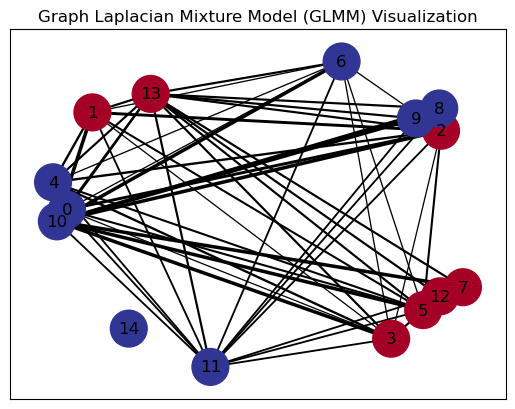

In [7]:

n = 15
m = 150
k = 2
zero_thresh = 10e-4

g = [generate_connected_graph(n, 0.7, zero_thresh) for _ in range(k)]

gamma = np.random.rand(m, 1)
gamma_cut = np.zeros((m, k))
dist = 0.5
p = np.linspace(0, 1, k + 1)
y = np.zeros((m, n))
true_y = np.zeros((m, n, k))
center = np.zeros((n, k))
gauss = np.zeros((n, n, k))
Lap = np.zeros((n, n, k))

for i in range(k):
    gc = pinv(g[i])
    gauss[:, :, i] = (gc + gc.T) / 2
    Lap[:, :, i] = g[i]
    center[:, i] = dist * np.random.randn(n)
    center[:, i] = center[:, i] - np.mean(center[:, i])
    gamma_cut[(p[i] < gamma[:, 0]) & (gamma[:, 0] <= p[i + 1]), i] = 1
    true_y[:, :, i] = gamma_cut[:, i][:, np.newaxis] * np.random.multivariate_normal(center[:, i], gauss[:, :, i], m)
    y += true_y[:, :, i]

iterations = 200
avg_nr_edges = 8
Ls, gamma_hats, mus, log_likelihood = glmm(y, iterations, k , avg_nr_edges)
print('Training done')

print(np.sum(gamma_hats, axis=0))

identify, precision, recall, f, cl_errors ,NMI_score , num_of_edges = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)

print("Identify:", identify)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f)
print("Cluster Errors:", cl_errors)
print('Normalized mutual information', NMI_score)
print("Number of estimated edges", num_of_edges)
summed_gamma_hats = np.sum(gamma_hats, axis=1)
summed_gamma_hats_column = summed_gamma_hats[:, np.newaxis]
are_all_elements_one = np.allclose(summed_gamma_hats_column, 1, atol=1e-8)
print("\nAre all elements in the colum wise summed gamma_hat equal to 1:", are_all_elements_one)
visualize_glmm(Ls, gamma_hats)

In [8]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import multivariate_normal as mvnpdf

# Assume gsp_distanz and gsp_learn_graph_log_degrees are defined and behave as in MATLAB.
# If gsp_distanz returns pairwise distances identical to MATLAB, and
# gsp_learn_graph_log_degrees is the exact python equivalent of the MATLAB function, results should match.

def glmm(y, iterations, classes, avg_nr_edges , spread=0.1, regul=0.15, norm_par=1.5):
    """
    Graph Laplacian Mixture Model (GLMM) - Python version closely aligned with MATLAB code.
    """
    # delta = 2
    m, n = y.shape

    # Initialize variables
    L = np.zeros((n, n, classes))
    W = np.zeros((n, n, classes))
    sigma = np.zeros((n-1, n-1, classes))
    mu = np.zeros((n, classes))
    gamma_hat = np.zeros((m, classes))
    p = np.zeros(classes)
    vecl = np.zeros((n, n, classes))
    vall = np.zeros((n, n, classes))
    yl = np.zeros((m, n-1, classes))
    log_likelihood = np.zeros(iterations)

    # Initialization as in MATLAB
    for cls in range(classes):
        L[:, :, cls] = spread * np.eye(n) - (spread / n) * np.ones((n, n))
        mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
        mu[:, cls] = mu_curr - np.mean(mu_curr)
        p[cls] = 1.0 / classes

    # Main loop
    for it in range(iterations):
        # E-step
        pall = 0
        for cls in range(classes):
            # Compute eigen decomposition
            eig_vals, eig_vecs = np.linalg.eig(L[:, :, cls])
            # Construct vall as a diagonal matrix of eigenvalues (as MATLAB's eig returns a diag matrix)
            vall[:, :, cls] = np.diag(eig_vals)
            vecl[:, :, cls] = eig_vecs

            # sigma = inv(vall(2:n,2:n,class) + regul*eye(n-1))
            # MATLAB indexing 2:n => python 1:n (zero-based)
            sub_val = vall[1:n, 1:n, cls] + regul * np.eye(n-1)
            sigma[:, :, cls] = inv(sub_val)
            # Ensure symmetry
            sigma[:, :, cls] = (sigma[:, :, cls] + sigma[:, :, cls].T) / 2

            # yl = (y - mu(:,class)') * vecl(:,2:n,class)
            yl[:, :, cls] = (y - mu[:, cls]) @ vecl[:, 1:n, cls]

            # pall += p(class)*mvnpdf(...) same dimension
            # MATLAB: mvnpdf(yl(:,:,class), zeros(1,n-1), sigma)
            # Python: mean = np.zeros(n-1), cov = sigma
            pall += p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])

        pall[pall == 0] = 0.1

        # gamma_hat
        for cls in range(classes):
            gamma_hat[:, cls] = (p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])) / pall

        log_likelihood[it] = np.sum(np.log(pall))

        # M-step
        for cls in range(classes):
            mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])

            # yc = repmat(sqrt(gamma_hat(:,class)),[1,n]) .* (y - mu(:,class)')
            yc = np.sqrt(gamma_hat[:, cls])[:, np.newaxis] * (y - mu[:, cls])

            # Z = gsp_distanz(yc).^2
            Z = (gsp_distanz(yc))**2

            # theta = mean(Z(:))/norm_par
            theta = np.mean(Z) / norm_par

            # W_curr = delta*gsp_learn_graph_log_degrees(Z./theta,1,1)
            # Python indexing: gsp_learn_graph_log_degrees returns (W,...)
            theta = gsp_compute_graph_learning_theta(Z, avg_nr_edges, geom_mean=1, is_sorted = 0)
            W_curr = (1/theta) * (gsp_learn_graph_log_degrees(Z * theta, 1, 1)[0])
            W[:, :, cls] = W_curr

            p[cls] = np.sum(gamma_hat[:, cls]) / m

            # Compute L
            L[:, :, cls] = np.diag(np.sum(W[:, :, cls], axis=1)) - W[:, :, cls]

            # Threshold small edges
            W_curr[W_curr < 1e-3] = 0
            W[:, :, cls] = W_curr

    return L, gamma_hat, mu, log_likelihood


# iters:   99. Rel primal: 9.0931e-06 Rel dual: 9.7130e-06 OBJ 5.334e+00
Time needed is 0.020855188369750977 seconds
# iters:  100. Rel primal: 9.3809e-06 Rel dual: 5.5630e-06 OBJ 5.248e+00
Time needed is 0.10459089279174805 seconds
# iters:  265. Rel primal: 2.5627e-11 Rel dual: 9.9765e-06 OBJ 8.030e+00
Time needed is 0.04822707176208496 seconds
# iters:  115. Rel primal: 9.8992e-06 Rel dual: 3.9930e-06 OBJ 9.239e+00
Time needed is 0.007544040679931641 seconds


/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/781319555.py:58: RuntimeWarning: divide by zero encountered in log
  final_eval = -gamma * np.sum(np.log(x))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/781319555.py:439: RuntimeWarning: divide by zero encountered in log
  g_eval = lambda z: -a * np.sum(np.log(z))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/781319555.py:58: RuntimeWarning: invalid value encountered in log
  final_eval = -gamma * np.sum(np.log(x))
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/1061622960.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  vall[:, :, cls] = np.diag(eig_vals)
/var/folders/0t/4q2l76sj2v91nwcfqht0bwlw0000gn/T/ipykernel_75295/1061622960.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  vecl[:, :, cls] = eig_vecs


# iters:  367. Rel primal: 2.6423e-14 Rel dual: 9.9076e-06 OBJ 1.229e+01
Time needed is 0.023212671279907227 seconds
# iters:  118. Rel primal: 9.4177e-06 Rel dual: 4.0106e-06 OBJ 1.177e+01
Time needed is 0.011736869812011719 seconds
# iters:  407. Rel primal: 5.5187e-16 Rel dual: 9.9152e-06 OBJ 1.204e+01
Time needed is 0.0350801944732666 seconds
# iters:  137. Rel primal: 4.0390e-06 Rel dual: 9.7664e-06 OBJ 1.289e+01
Time needed is 0.013829946517944336 seconds
# iters:  382. Rel primal: 2.8334e-14 Rel dual: 9.8909e-06 OBJ 1.237e+01
Time needed is 0.04609107971191406 seconds
# iters:  123. Rel primal: 5.8887e-06 Rel dual: 9.8667e-06 OBJ 1.252e+01
Time needed is 0.0066890716552734375 seconds
# iters:  407. Rel primal: 6.2035e-16 Rel dual: 9.9064e-06 OBJ 1.204e+01
Time needed is 0.03141307830810547 seconds
# iters:  137. Rel primal: 4.0427e-06 Rel dual: 9.7691e-06 OBJ 1.289e+01
Time needed is 0.006618022918701172 seconds
# iters:  488. Rel primal: 0.0000e+00 Rel dual: 9.9467e-06 OBJ 1.24

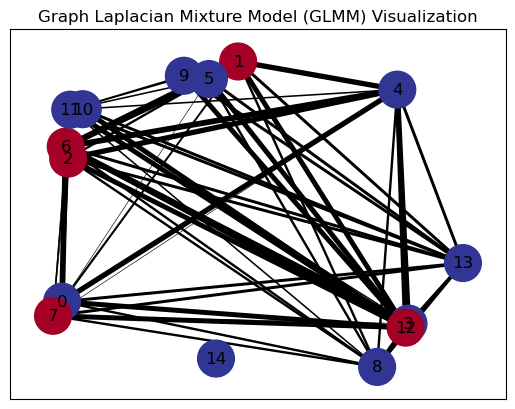

In [10]:

n = 15
m = 150
k = 2
zero_thresh = 10e-4

g = [generate_connected_graph(n, 0.7, zero_thresh) for _ in range(k)]

gamma = np.random.rand(m, 1)
gamma_cut = np.zeros((m, k))
dist = 0.5
p = np.linspace(0, 1, k + 1)
y = np.zeros((m, n))
true_y = np.zeros((m, n, k))
center = np.zeros((n, k))
gauss = np.zeros((n, n, k))
Lap = np.zeros((n, n, k))

for i in range(k):
    gc = pinv(g[i])
    gauss[:, :, i] = (gc + gc.T) / 2
    Lap[:, :, i] = g[i]
    center[:, i] = dist * np.random.randn(n)
    center[:, i] = center[:, i] - np.mean(center[:, i])
    gamma_cut[(p[i] < gamma[:, 0]) & (gamma[:, 0] <= p[i + 1]), i] = 1
    true_y[:, :, i] = gamma_cut[:, i][:, np.newaxis] * np.random.multivariate_normal(center[:, i], gauss[:, :, i], m)
    y += true_y[:, :, i]

iterations = 200
avg_nr_edges = 4
avg_nr_edges = 10
Ls, gamma_hats, mus, log_likelihood = glmm(y, iterations, k , avg_nr_edges)
print('Training done')

print(np.sum(gamma_hats, axis=0))

identify, precision, recall, f, cl_errors ,NMI_score , num_of_edges = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)

print("Identify:", identify)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f)
print("Cluster Errors:", cl_errors)
print('Normalized mutual information', NMI_score)
print("Number of estimated edges", num_of_edges)
summed_gamma_hats = np.sum(gamma_hats, axis=1)
summed_gamma_hats_column = summed_gamma_hats[:, np.newaxis]
are_all_elements_one = np.allclose(summed_gamma_hats_column, 1, atol=1e-8)
print("\nAre all elements in the colum wise summed gamma_hat equal to 1:", are_all_elements_one)
visualize_glmm(Ls, gamma_hats)